### Imports

In [3]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import scipy.stats as stats
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import math
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

### Read every cohort study file

In [4]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [6]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [7]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [8]:
# add the preprocessed columns from sub table of each dataset to the main table of dataset
for i in cohort_studies:
#     cols = cohort_studies_sub[i].columns.difference(cohort_studies[i].columns)
    cols = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
    
    for col in cols:
        
        if col in cohort_studies_sub[i].columns:
            cohort_studies[i][col] = cohort_studies_sub[i][col]

### Read harmonized mapping tables

In [9]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [10]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [11]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [12]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [13]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [14]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [15]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [16]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Read cutoffs obtained using all methods

In [17]:
table_method = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../results/cutoffs/' + "/*."+'csv'))]
method_name = [file.split(".")[0] for file in sorted(os.listdir('../results/cutoffs/'))]

In [18]:
# make a dictionary that contains each cutoff table as a dataframe
cutoffs_ = dict()

for tm, mn in zip(table_method, method_name):
    cutoffs_[mn] = tm

In [19]:
[cutoffs_['km_cutoffs'].rename(columns={col: col.split('_')[0]}, inplace=True) for col in cutoffs_['km_cutoffs'].columns]

[None, None, None]

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [20]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [21]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [22]:
# atn

In [23]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [24]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [25]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [26]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [27]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [28]:
cohort_studies['ADNI'] = cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR', 'LDELTOTAL_BL': 'LDELTOTAL'})

### CSF biomarkers, two classes, normal vs abnormal

In [29]:
# modality_ = ['clinical_i', 'clinical_ii','hippocampus', 'csf']
# modality_ = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'clinical_i', 
#             'clinical_ii', 'csf', 'diencephalus', 'general_brain', 
#             'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']
modality_ = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'csf', 'diencephalus', 'general_brain', 
            'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']

selected_feat = dict()

for i in modality_:
    selected_feat[i] = mappings[i]

In [30]:
# make a dataframe containing all the mapped features
features_all = pd.concat(selected_feat, ignore_index=True)

In [31]:
features_all = features_all[atn.index.union(['Feature', 'Rank'])] # subset the cohorts of interest

In [32]:
# remove the features that are not available in all studies
features_all = features_all.loc[features_all['Feature'].isin(existing_features[atn.index.union(['Feature'])].dropna(how='all')['Feature'].to_list())]

### Convert MRI measurements to mm3, same as ADNI and other cohorts

In [33]:
mri_nacc = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'diencephalus', 'general_brain', 
            'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']

for i in mri_nacc:
    
    for variable in mappings[i][['Feature', 'NACC']].dropna()['Feature'].to_list():
        
        if "Volume" in variable:
            nacc_var = mappings[i].loc[mappings[i]['Feature']==variable, 'NACC']
            cohort_studies['NACC'][nacc_var] = cohort_studies['NACC'][nacc_var] * 1000

In [34]:
nacc_mri_to_convert = list()

for i in mri_nacc:
    
    for feat_ in mappings[i]['NACC'].dropna().to_list():
        nacc_mri_to_convert.append(feat_)

* Rank 1 --> Categorical features
* Rank 2 --> Taboo features: some categorical and some numerical
* Rank nan --> Numerical features 

replace nan with 0

In [35]:
features_all['Rank'].replace({np.nan: 0}, inplace=True)

In [36]:
features_all.replace({"No total score.": np.nan}, inplace=True)

In [37]:
# fix PharmaCog column names
for i in cohort_studies['PharmaCog'].columns:
    if "\xa0" in i:
        new = str(i).replace(u'\xa0', u'')
        cohort_studies['PharmaCog'].rename(columns={i: new}, inplace=True)

## Prepare datasets

In [38]:
def umap_atn_participants(dfss, cohorts, thresholds, features):
    """cohorts: list of cohort names 
       dfss: dictionary of cohorts where each key is the name of a cohort
       thresholds: cutoff values obtained using a methodology
       
       Select the features and participants and categorize the participant into ATN profiles using thresholds
       obtained from each methodology.
       
       return a df which contain the combination of paticipant from the selected cohorts while harmonizing
       the features names.
    """
    
    # make a list of additional features to be investigated 
#     additional_feat = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
    additional_feat = ['APOE4']

    # make an empty dictionary to add the datasets to
    df_= pd.DataFrame(columns=set(features.loc[features['Rank']==0]
                                  [cohorts + ['Feature']].dropna()['Feature']).difference(['Feature'] + list(thresholds.columns)).union(additional_feat))
   
    for i in cohorts:
#         print(i)

        dfs = dict()
        dfs[i] = dfss[i].copy() # make a copy of the dataset of interest
        # select the subset of datasets with features to be investigated
        dfs[i] = dfs[i][features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list() + additional_feat].dropna(axis=1, how='all')
        # rename all the columns so we can concat the datasets later
        [dfs[i].rename(columns={col: coln}, inplace=True) for col, coln in 
         zip(features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list(), 
             features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()['Feature'].to_list())]
        dfs[i]['Cohort'] = i # add a cohort name column
        # change the datatype to str as these are categorical features. astype doesn't work as it will include nan values
        dfs[i] = dfs[i].replace({'APOE4': {0.0: '0', 2.0: '2', 1.0: '1'}}) 

        if i!='NACC':
            
            for biomarker in thresholds.columns:
                # select the cutoff value for each biomarker for each cohort
                threshold = thresholds.loc[i][biomarker]

                # dichotomize the participants
                if biomarker == 'pTau in CSF': 
                    dfs[i].loc[dfs[i][biomarker]>threshold, "T"] = 'T+'
                    dfs[i].loc[dfs[i][biomarker]<threshold, "T"] = 'T-'

                elif biomarker == 'tTau in CSF': 
                    dfs[i].loc[dfs[i][biomarker]>threshold, "N"] = 'N+'
                    dfs[i].loc[dfs[i][biomarker]<threshold, "N"] = 'N-'

                else: 
                    dfs[i].loc[dfs[i][biomarker]<threshold, "A"] = 'A+'
                    dfs[i].loc[dfs[i][biomarker]>threshold, "A"] = 'A-'

            # join the 3 columns to make the final ATN categorie                                 
            dfs[i]['ATN'] = dfs[i]['A'] + dfs[i]['T'] + dfs[i]['N']
            # remove the columns that we are not interested in
            dfs[i] = dfs[i][dfs[i].columns.difference(['A', 'T', 'N', 'Mini-Mental State Examination (MMSE)'] + list(thresholds.columns))]
            
        else:
            
            elisa_index = cohort_studies[i].loc[(cohort_studies[i]['CSFTTMD']==1)].index
            xmap_index = cohort_studies[i].loc[(cohort_studies[i]['CSFTTMD']==2)].index
            
            for biomarker in thresholds.columns:
                # select the cutoff value for each biomarker for each cohort
                elisa = thresholds.loc[i + "_ELISA"][biomarker] # ELISA
                xmap = thresholds.loc[i + "_XMAP"][biomarker] #XMAP

                # dichotomize the participants
                if biomarker == 'pTau in CSF': 
                    
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "T"] = 'T+'
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "T"] = 'T-'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "T"] = 'T+'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "T"] = 'T-'

                elif biomarker == 'tTau in CSF': 
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "N"] = 'N+'
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "N"] = 'N-'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "N"] = 'N+'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "N"] = 'N-'

                else: 
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "A"] = 'A+'
                    dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "A"] = 'A-'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "A"] = 'A+'
                    dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "A"] = 'A-'

            # join the 3 columns to make the final ATN categorie                                 
            dfs[i]['ATN'] = dfs[i]['A'] + dfs[i]['T'] + dfs[i]['N']
            # remove the columns that we are not interested in
            dfs[i] = dfs[i][dfs[i].columns.difference(['A', 'T', 'N', 'Mini-Mental State Examination (MMSE)', 'Trail Making Test (TMT) A', 'Verbal fluency tests (Semantic) Animal'] + list(thresholds.columns))]
            
#         print(dfs[i])

        
        df_ = pd.concat([df_, dfs[i]])
#         print(df_)
#         df_ = df_.dropna(axis=1, thresh=len(df_.index)/2)
#         print(df_)
    
    df_ = df_.dropna(axis=1, how='all')
    df_ = df_.dropna(axis=1, thresh=1200)

    df_ = df_.dropna()

    return df_

In [39]:
# umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all)

In [40]:
# test = umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all)

In [41]:
# umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all)

In [42]:
# Counter(umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all).Cohort)

In [43]:
# umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all).columns.difference(umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all).dropna(axis=1, thresh=1000).columns)

In [44]:
# Counter(umap_atn_participants(cohort_studies, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['km_cutoffs'], features_all).Cohort)

In [45]:
# umap_atn_participants(cohort_studies, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'], cutoffs_['gmm_cutoffs'], features_all)

In [46]:
def norm_df(df, cohorts_l):
    """df: concatenated df, containing participants of interested cohort studies
    cohorts_l: a list of cohorts that are contain in the df
    normalize the continuous features and apply dummy variable method for categorical features
    return: a dictionary where the keys are the cohort name and the values are dfs containing preprocessed values 
    """
    cohort_dict = dict()
    
    for i in cohorts_l:
        sub_df = df.loc[df['Cohort']==i]
        # make dummy variables and normalize features 
#         num = sub_df[sub_df.select_dtypes(exclude='object').columns.difference(['APOE4'])].apply(stats.zscore)
        num = sub_df[sub_df.select_dtypes(exclude='object').columns.difference(['APOE4'])]
        cat = pd.get_dummies(sub_df[sub_df.select_dtypes(include='object').columns.difference(['ATN', 'Cohort'])].dropna())
        others = sub_df[['ATN', 'Cohort']]
        data_f = pd.concat([num, cat, others], axis=1)
        cohort_dict[i] = data_f
        
    return cohort_dict

In [47]:
# norm_df(test, ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

In [48]:
def cohorts_vs_method(cohortsss, methods=None):
    """
    cohortsss: selected cohorts for UMAP analysis
    methods: a list of methods 
    call the functions to preprocess the cohorts
    return: a dictionary where the keys are methods for obtaining thresholds and values are df containing the 
    preprocessed datasets (containing the selected features and cohorts)
    """
    
    result_dfs = dict()
    
    if methods != None:
        
        for method in methods:
#             print(method)
            umap_df = umap_atn_participants(cohort_studies, cohortsss, cutoffs_[method], features_all)
            umap_df_concat = pd.concat(norm_df(umap_df, cohortsss), ignore_index=True)

            for i, j in zip(cohortsss, list(range(len(cohortsss)))):
                umap_df_concat.replace({i: j}, inplace=True) # replace cohort names with int values

            atn_parti = Counter(umap_df_concat['ATN'])
            remove_atn = list()

            for i in atn_parti:

                if atn_parti[i] < 20:
                    remove_atn.append(i)

            for atn_r in remove_atn:
                umap_df_concat = umap_df_concat.loc[umap_df_concat['ATN']!=atn_r]

            result_dfs[method] = umap_df_concat.dropna(axis=1)
            
    else:
        
        for method in set(cutoffs_.keys()).difference(["cutoffs_cohort_study"]):
            umap_df = umap_atn_participants(cohort_studies, cohortsss, cutoffs_[method], features_all)
            umap_df_concat = pd.concat(norm_df(umap_df, cohortsss), ignore_index=True)

            for i, j in zip(cohortsss, list(range(len(cohortsss)))):
                umap_df_concat.replace({i: j}, inplace=True)

            atn_parti = Counter(umap_df_concat['ATN'])
            remove_atn = list()

            for i in atn_parti:

                if atn_parti[i] < 20:
                    remove_atn.append(i)

            for atn_r in remove_atn:
                umap_df_concat = umap_df_concat.loc[umap_df_concat['ATN']!=atn_r]

            result_dfs[method] = umap_df_concat.dropna(axis=1)

    return result_dfs

In [49]:
# cohorts_vs_method(['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['km_cutoffs'])['km_cutoffs']

In [50]:
# adni_epad = cohorts_vs_method(['ADNI', 'EPAD'])

In [51]:
# aaep = cohorts_vs_method(['ADNI', 'ARWIBO', 'EPAD', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [52]:
# aanep = cohorts_vs_method(['ADNI', 'ARWIBO', 'NACC', 'EPAD', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [53]:
# aanedp = cohorts_vs_method(['ADNI', 'ARWIBO', 'NACC', 'EPAD', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [54]:
# aanejdp = cohorts_vs_method(['ADNI', 'ARWIBO', 'NACC', 'EPAD', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [55]:
# aaejdp_last = cohorts_vs_method(['ADNI', 'ARWIBO', 'EPAD', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [56]:
# aajdp_last_last = cohorts_vs_method(['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [57]:
# last_umap_combo = cohorts_vs_method(['ADNI', 'EDSD', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

In [58]:
seven_cohorts_ = cohorts_vs_method(['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

#### exclude CSF Volume as it seems wrong in the NACC dataset and that could potentially add bias to our analysis

In [59]:
no_csf_vol= dict()

for i in seven_cohorts_:
    no_csf_vol[i] = seven_cohorts_[i][seven_cohorts_[i].columns[1:]]

In [60]:
# cohorts_vs_method(['ADNI', 'EDSD', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

### end

In [83]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def plot_result(dfs_dict, list_cohort):
    """"""
    
    method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}
    
#     colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
#           'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
#           'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
#           'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
#           'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}
    
    
#     if len(list_cohort) < 3:
#         title_cohs = ' and '.join([str(item) for item in list_cohort])
            
#     else:
#         title_cohs = ', '.join([str(item) for item in list_cohort[:-1]]) + ' and ' + list_cohort[-1]
    
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(10, 3 * len(df['ATN'].unique())))
        
        patches = list()
        colors = np.array(['#f781bf', '#229ce3', '#ff7f0e', '#24b544', '#7c22e3', '#8c564b', '#ffbb78', '#98df8a', 
                  '#ff9896', '#c49c94', '#c7c7c7'])
        
        for n in list_cohort:
            patches.append(Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[list_cohort.index(n)], label=n))

        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN'])], 
                    y=df.loc[df['ATN']==atn_]['Cohort'])
            print(atn_, embedding.shape)
            print(*embedding.T)
            
            plt.ylabel(f"{met}", loc='center')
            
#             plt.legend(handles=patches, fontsize=14, ncol=2, markerscale=1.5)

            scatter = axes[ind].scatter(*embedding.T, s=40, c=colors[df.loc[df['ATN']==atn_]['Cohort']], cmap='Spectral', alpha=.7, label=list_cohort)
            plt.setp(axes[ind], xticks=[], yticks=[])
                     
            axes[ind].set_title(f'{atn_}', fontsize=15)
#             fig.suptitle(f'ATN based comparision among the {title_cohs} cohorts')
#             fig.suptitle(f'Coherence of ATN profiles across cohorts', fontsize=20, fontweight='bold')
            fig.suptitle(f'{method_names[met]}', fontsize=17, fontweight='bold')

            fig.subplots_adjust(top=0.95)
            fig.text(.05,.5, 'SOMETHING', ha='center', va='center', rotation=90, fontstyle='normal')
            fig.supylabel(f"{method_names[met]}", fontsize=15)
#             plt.savefig(f"../results/umap/final_plots/{met}_{'_'.join(list_cohort)}_minus20pat.png", dpi=300, bbox_inches='tight')

In [106]:
mapper = umap.UMAP(n_neighbors=5).fit_transform(no_csf_vol['gmm_cutoffs'].loc[no_csf_vol['gmm_cutoffs']['ATN']=='A+T+N-'][no_csf_vol['gmm_cutoffs'].columns.difference(['Cohort', 'ATN'])], 
                    y=no_csf_vol['gmm_cutoffs'].loc[no_csf_vol['gmm_cutoffs']['ATN']=='A+T+N-']['Cohort'])

In [107]:
import umap.plot

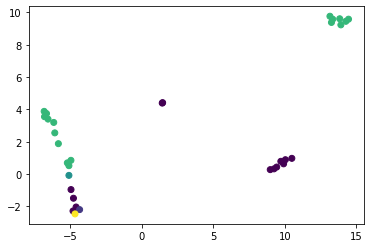

In [114]:
plt.scatter(*mapper.T, c=no_csf_vol['gmm_cutoffs'].loc[no_csf_vol['gmm_cutoffs']['ATN']=='A+T+N-']['Cohort'])

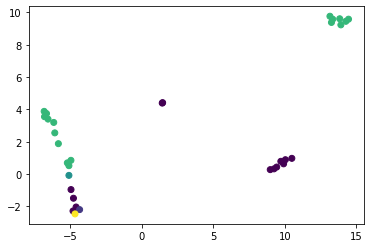

In [112]:
plt.scatter(mapper[:, 0], mapper[:, 1], c=no_csf_vol['gmm_cutoffs'].loc[no_csf_vol['gmm_cutoffs']['ATN']=='A+T+N-']['Cohort'])

In [1]:
# no_csf_vol['gmm_cutoffs'].loc[no_csf_vol['gmm_cutoffs']['ATN']=='A-T-N-']['Cohort']

In [2]:
# no_csf_vol['gmm_cutoffs']

In [3]:
# plot_result(no_csf_vol, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

#### Check the number of participants in each cohort

In [87]:
# gmm_participants_umap = pd.DataFrame.from_dict(Counter(no_csf_vol['gmm_cutoffs']['Cohort']), orient='index')
# km_participants_umap = pd.DataFrame.from_dict(Counter(no_csf_vol['km_cutoffs']['Cohort']), orient='index')

In [88]:
# cohort_names_7 = ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
# for i, j in zip(cohort_names_7, range(len(cohort_names_7))):
#     print(i, j)
#     gmm_participants_umap.rename(index={j: i}, inplace=True)
#     km_participants_umap.rename(index={j: i}, inplace=True) 

ADNI 0
EDSD 1
ARWIBO 2
NACC 3
JADNI 4
DOD-ADNI 5
PharmaCog 6


In [92]:
# gmm_participants_umap

,0
ADNI,589
EDSD,63
ARWIBO,80
NACC,196
JADNI,187
DOD-ADNI,70
PharmaCog,143


In [93]:
# km_participants_umap.sum()

0    1316
dtype: int64

In [2]:
# for i in no_csf_vol:
#     print(i, no_csf_vol[i].shape)
#     print(i, Counter(no_csf_vol[i]['Cohort']))

In [1]:
# no_csf_vol['gmm_cutoffs'].columns[:-4] # number of features included in UMAP

In [105]:
# pd.DataFrame(no_csf_vol['gmm_cutoffs'].columns).to_csv('../results/umap/final_plots/seven_cohort_features.csv')

In [79]:
# aajdp_last_last['km_cutoffs'].columns.difference(set(pd.DataFrame(last_umap_combo['km_cutoffs'].columns)[0]))

In [80]:
# pd.DataFrame(last_umap_combo['gmm_cutoffs'].columns).to_csv("../results/umap/umap_feature.csv")

In [81]:
# Counter(seven_cohorts_['km_cutoffs'].Cohort)

Counter({0: 591, 1: 64, 2: 81, 3: 196, 4: 187, 5: 70, 6: 143})

### Testing

In [82]:
# features_all[['Feature', 'ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog']].dropna()['Feature'].to_list()

In [83]:
# cohort_studies['ADNI'].rename_axis('ID')

In [84]:
# cohort_studies_new = dict()
# for i in ['ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog']:
#     [cohort_studies[i].rename(columns={col: coln}, inplace=True) for col, coln in 
#          zip(features_all[[i, 'Feature']].dropna()[i].to_list(), 
#              features_all[[i, 'Feature']].dropna()['Feature'].to_list())]
    
#     cohort_studies[i] = cohort_studies[i].rename_axis('ID')
    
#     cohort_studies_new[i] = cohort_studies[i]

In [85]:
# testing_ = pd.concat(cohort_studies_new.values()).dropna(axis=1, thresh=1000)[features_all[['Feature', 'ADNI', 'ARWIBO', 'JADNI', 'DOD-ADNI', 'PharmaCog']].dropna()['Feature'].to_list()].dropna(axis=1, how='all')

In [86]:
# testing_.shape

In [87]:
# testing_.dropna(axis=1, thresh=1200).dropna(axis=0)

In [88]:
# Counter(dict(testing_.isna().sum()).values())

In [89]:

# with PdfPages('../results/umap/final_plots/test_hist.pdf') as pdf:
#     for i in seven_cohorts_:
        
#         coh = seven_cohorts_[i].loc[(seven_cohorts_[i]['Cohort']==0) | (seven_cohorts_[i]['Cohort']==3)]
#         for each_ATN in coh.ATN.unique():

#             for feat in coh.columns[:-5]:
#                 fig, axes = plt.subplots(1, 2, figsize=(15,5))

#                 axes[0].hist(coh.loc[(coh['Cohort']==0) & (coh['ATN']==each_ATN)][feat])
#                 axes[1].hist(coh.loc[(coh['Cohort']==3) & (coh['ATN']==each_ATN)][feat])

#                 axes[0].set_title(f"{feat} in ADNI ({i.split('_')[0].upper()} - {each_ATN})")
#                 axes[1].set_title(f"{feat} in NACC ({i.split('_')[0].upper()} - {each_ATN})")

#                 fig.get_figure()
#                 pdf.savefig(fig)

# # fig.savefig("../results/umap/final_plots/test_hist.pdf", bbox_inches='tight')

In [90]:
# for i in seven_cohorts_:
#     coh = seven_cohorts_[i].loc[(seven_cohorts_[i]['Cohort']==0) | (seven_cohorts_[i]['Cohort']==3)]
    
#     for each_ATN in coh.ATN.unique():
#         print(len(coh.loc[(coh['Cohort']==0) & (coh['ATN']==each_ATN)])!=0)
        
#         if len(coh.loc[(coh['Cohort']==0) & (coh['ATN']==each_ATN)])!=0 and len(coh.loc[(coh['Cohort']==3) & (coh['ATN']==each_ATN)])!=0:
#             print('yes')
        
#             with PdfPages(f'../results/umap/final_plots/hist_{each_ATN}_{i}.pdf') as pdf:

#                 for feat in coh.columns[:-5]:
#                     fig = plt.figure()
#                     sns.histplot(coh.loc[coh['ATN']==each_ATN], x=feat, hue='Cohort')
#                     plt.title(f"{feat} using {i.split('_')[0].upper()} method for {each_ATN} ")


#                     fig.get_figure()
#                     pdf.savefig(fig)
